# Introduction 
This guide will cover the basic steps of data cleaning and fitting models, with a focus on ensemble model methods like bagging and boosting. This data contains demographic and financial information from several credit card companies in Taiwan from April to September 2005. The main focus of our study will be determining whether we can predict whether a customer will default based on their financial and demographic information. We will begin by examining the data by interpreting the variables and their importance.

# Data Exploration
We can begin by loading in our data and identifying the variables we were given. This was done in the Kaggle coding environment. We also imported some basic libraries we are likely to use.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
dataset = pd.read_csv('../input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
dataset.head()

/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


We can see that we are given some demographic information (sex, marriage status, and age), their financial history (payment status, bill amount, and payment amount for six months) and some additional information like their balance limit and whether they defaulted the next month, which is our response variable. Our PAY_0 variable doesn't match the other two variables of BILL_AMT1 and PAY_AMT1, so we will rename it. At the same time, we can rename the default variable so it is easier to reference later.

In [2]:
dataset = dataset.rename(columns={'PAY_0':'PAY_1', 'default.payment.next.month':'DEFAULT'})
dataset.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


We can now begin to look at the properties of our variables and their interaction with each other. We can begin by listening the variables with their information, looking for missing values or odd labels.

In [3]:
for col in dataset:
    print(col, dataset[col].unique())

ID [    1     2     3 ... 29998 29999 30000]
LIMIT_BAL [  20000.  120000.   90000.   50000.  500000.  100000.  140000.  200000.
  260000.  630000.   70000.  250000.  320000.  360000.  180000.  130000.
  450000.   60000.  230000.  160000.  280000.   10000.   40000.  210000.
  150000.  380000.  310000.  400000.   80000.  290000.  340000.  300000.
   30000.  240000.  470000.  480000.  350000.  330000.  110000.  420000.
  170000.  370000.  270000.  220000.  190000.  510000.  460000.  440000.
  410000.  490000.  390000.  580000.  600000.  620000.  610000.  700000.
  670000.  680000.  430000.  550000.  540000. 1000000.  530000.  710000.
  560000.  520000.  750000.  640000.   16000.  570000.  590000.  660000.
  720000.  327680.  740000.  800000.  760000.  690000.  650000.  780000.
  730000.]
SEX [2 1]
EDUCATION [2 1 3 5 4 6 0]
MARRIAGE [1 2 3 0]
AGE [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70

# Data Cleaning
While we don't have any NA's in our dataset, we do have some unusual coding of values. Education is supposed to be a value from 1-6, but our dataset shows some values of 0. The case is the same with marriage status. Our payment status (PAY_1 - PAY_6) should be -1 for due payment, and 1-9 for payment delay by month, but we see values of -2 and 0. for marriage and education, the 0 appears to represent either an NA or other value, so we will include them in the other categories (3 and 4) for their respective variables. For education, we will combine the values 5, 6, and 0 into the variable 4. For marriage, we will combine 0 to 3.

In [4]:
others = (dataset.EDUCATION == 5) | (dataset.EDUCATION == 6) | (dataset.EDUCATION == 0)
dataset.loc[others, 'EDUCATION'] = 4
print('EDUCATION', dataset.EDUCATION.unique())

EDUCATION [2 1 3 4]


In [5]:
dataset.loc[dataset.MARRIAGE == 0, 'MARRIAGE'] = 3
print('MARRIAGE', dataset.MARRIAGE.unique())

MARRIAGE [1 2 3]


For our final variable to fix, payment status, -2, -1, and 0 all appear to be showing different states of non-late status. For example, the customer could have paid in full, no activity was done on the card,  or there may have been a credit on the account. We can combine all of these values to 0 to reflect a single status of being non-late on payment in full.

In [6]:
others = (dataset.PAY_1 == 0) | (dataset.PAY_1 == -1) | (dataset.PAY_1 == -2)
dataset.loc[others, 'PAY_1'] = 0
print('PAY_1', dataset.PAY_1.unique())

others = (dataset.PAY_2 == 0) | (dataset.PAY_2 == -1) | (dataset.PAY_2 == -2)
dataset.loc[others, 'PAY_2'] = 0
print('PAY_2', dataset.PAY_2.unique())

others = (dataset.PAY_3 == 0) | (dataset.PAY_3 == -1) | (dataset.PAY_3 == -2)
dataset.loc[others, 'PAY_3'] = 0
print('PAY_3', dataset.PAY_3.unique())

others = (dataset.PAY_4 == 0) | (dataset.PAY_4 == -1) | (dataset.PAY_4 == -2)
dataset.loc[others, 'PAY_4'] = 0
print('PAY_4', dataset.PAY_4.unique())

others = (dataset.PAY_5 == 0) | (dataset.PAY_5 == -1) | (dataset.PAY_5 == -2)
dataset.loc[others, 'PAY_5'] = 0
print('PAY_5', dataset.PAY_5.unique())

others = (dataset.PAY_6 == 0) | (dataset.PAY_6 == -1) | (dataset.PAY_6 == -2)
dataset.loc[others, 'PAY_6'] = 0
print('PAY_6', dataset.PAY_6.unique())

PAY_1 [2 0 1 3 4 8 7 5 6]
PAY_2 [2 0 3 5 7 4 1 6 8]
PAY_3 [0 2 3 4 6 7 1 5 8]
PAY_4 [0 2 3 4 5 7 6 1 8]
PAY_5 [0 2 3 5 4 7 8 6]
PAY_6 [0 2 3 6 4 7 8 5]


# Feature Engineering
The final thing to accomplish is to sum up the bill and payment amounts into a new variable. A variable that shows the difference between the payments and the bills might be more useful, since it shows which accounts were revolving credit users, and by how much. I would also like to create a credit utilization variable that shows the difference between their amount owed and their total balance limit, since some users might have a high income. I will drop the variables we summarized so that they don't repeat in the prediction models.

In [7]:
SUM_BILLS = dataset["BILL_AMT1"] + dataset["BILL_AMT2"] + dataset["BILL_AMT3"] + dataset["BILL_AMT4"] + dataset["BILL_AMT5"] + dataset["BILL_AMT6"]
SUM_PAYS = dataset["PAY_AMT1"] + dataset["PAY_AMT2"] + dataset["PAY_AMT3"] + dataset["PAY_AMT4"] + dataset["PAY_AMT5"] + dataset["PAY_AMT6"]
BILL_PAY_DIFF = SUM_BILLS - SUM_PAYS
dataset["BILL_PAY_DIFF"] = BILL_PAY_DIFF
CREDIT_UTIL = dataset["BILL_PAY_DIFF"] / dataset["LIMIT_BAL"]
dataset["CREDIT_UTIL"] = CREDIT_UTIL
# dataset = dataset.drop(columns=["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"])
# dataset = dataset.drop(columns=["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"])
dataset = dataset.drop(columns=["ID"])
print(dataset)

       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0        20000.0    2          2         1   24      2      2      0      0   
1       120000.0    2          2         2   26      0      2      0      0   
2        90000.0    2          2         2   34      0      0      0      0   
3        50000.0    2          2         1   37      0      0      0      0   
4        50000.0    1          2         1   57      0      0      0      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29995   220000.0    1          3         1   39      0      0      0      0   
29996   150000.0    1          3         2   43      0      0      0      0   
29997    30000.0    1          2         2   37      4      3      2      0   
29998    80000.0    1          3         1   41      1      0      0      0   
29999    50000.0    1          2         1   46      0      0      0      0   

       PAY_5  ...  BILL_AMT6  PAY_AMT1  PAY_AMT2  P

We can create a simple heatmap to show the correlation between all of our cleaned variables. It looks like some demographic information could be important, we could create combinations of sex and marriage (singled man, married woman, etc.) to see if they have more influence on the outcome. We won't do that in this notebook, but it is worth considering.

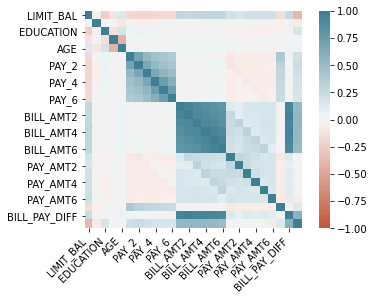

In [8]:
corr = dataset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Algorithms
We will first fit some simple models like regression, naive bayes, and some others to see what the data responds to. We can split the data into a train set and test set so that we can evaluate the effectiveness of the models. Our split will be 80-20, which should be sufficient since we have many observations.

In [9]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

card = dataset
x, y = card.drop('DEFAULT',axis=1), card.DEFAULT
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=44)

#create an array of models
models = []
models.append(("Logistic Regression",LogisticRegression(max_iter=100000)))
models.append(("Naive Bayes",GaussianNB()))
models.append(("Random Forest",RandomForestClassifier()))
models.append(("Support Vector",SVC()))
models.append(("Decision Tree",DecisionTreeClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2)
    cv_result = cross_val_score(model,x_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

Logistic Regression [0.77908333 0.77741667]
Naive Bayes [0.35116667 0.36391667]
Random Forest [0.81525 0.81525]
Support Vector [0.77925    0.77741667]
Decision Tree [0.726      0.73016667]
KNN [0.74883333 0.74583333]


A simple random forest is looking like the best option based on the cross validation scores. It is a bagging ensemble method, so we can try other bagging methods as well. A random forest works by selecting features and building deep trees, and combining them into a final ensemble model. We will display the score for training to show whether we may be overfitted, along with the score on test data. We will also show the ROC/AUC curve along with the table showing precision, recall, and the F1 score.

In [10]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

rf = RandomForestClassifier(n_estimators=10)
rf.fit(x_train,y_train)
print('train rf.score: ', rf.score(x_train,y_train))
print('test rf.score: ', rf.score(x_test,y_test))
final_pred = rf.predict(x_test)

train rf.score:  0.9787916666666666
test rf.score:  0.8091666666666667


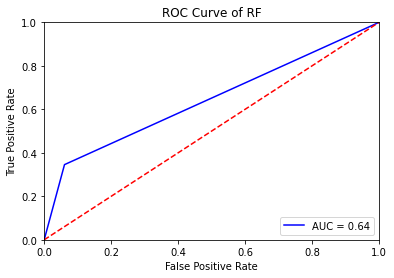

In [11]:
from sklearn.metrics import roc_curve, classification_report
from sklearn.metrics import auc

false_positive, true_positive, threshold = roc_curve(y_test, final_pred)
roc_auc = auc(false_positive, true_positive)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive, true_positive, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of RF')
plt.show()


In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

fmeasure1 = f1_score(y_test, final_pred, average="macro")
fmeasure2 = f1_score(y_test, final_pred, average="micro")

precision = precision_score(y_test, final_pred, average="macro")
recall = recall_score(y_test, final_pred, average="macro")
f1 = 2*(precision*recall)/(precision + recall)

print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1: " + str(f1))

tn, fp, fn, tp = confusion_matrix(y_test, final_pred).ravel()
print(classification_report(y_test, final_pred))

Precision: 0.7260198941376519
Recall: 0.6425563711684866
F1: 0.6817430937527833
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      4684
           1       0.62      0.35      0.44      1316

    accuracy                           0.81      6000
   macro avg       0.73      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000



We can repeat the process with a bagging classifier model to have a comparison. A bagging classifier uses bootsrapped samples instead of feature trees, but is in the same category as a random forest.

In [13]:
bg = BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5, max_features=1.0, n_estimators=20)
bg.fit(x_train,y_train)
bg.score(x_train,y_train)
bg.score(x_test,y_test)
print('train bagging score: ', bg.score(x_train,y_train))
print('test bagging score: ', bg.score(x_test,y_test))
final_pred = bg.predict(x_test)

train bagging score:  0.9294166666666667
test bagging score:  0.8195


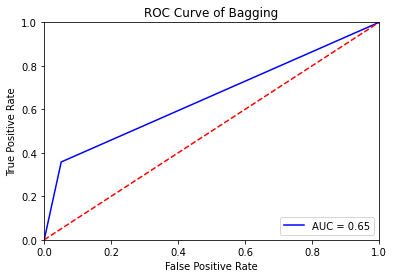

In [14]:
from sklearn.metrics import roc_curve, classification_report
from sklearn.metrics import auc

false_positive, true_positive, threshold = roc_curve(y_test, final_pred)
roc_auc = auc(false_positive, true_positive)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive, true_positive, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Bagging')
plt.show()

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

fmeasure1 = f1_score(y_test, final_pred, average="macro")
fmeasure2 = f1_score(y_test, final_pred, average="micro")

precision = precision_score(y_test, final_pred, average="macro")
recall = recall_score(y_test, final_pred, average="macro")
f1 = 2*(precision*recall)/(precision + recall)

print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1: " + str(f1))

tn, fp, fn, tp = confusion_matrix(y_test, final_pred).ravel()
print(classification_report(y_test, final_pred))

Precision: 0.7523053891178009
Recall: 0.6535457315727861
F1: 0.6994566759752268
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4684
           1       0.66      0.36      0.47      1316

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



Just to test a method we haven't used to see if there is an improvement, we will run a final model, Adaptive Boosting. Boosting is an iterative technique that adjusts the weights of our observations based on classification and the resulting regressions.  

In [16]:
ad = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=10, learning_rate=0.01)
ad.fit(x_train,y_train)
ad.score(x_train,y_train)
ad.score(x_test,y_test)
print('train adaboost score: ', ad.score(x_train,y_train))
print('test adaboost score: ', ad.score(x_test,y_test))

train adaboost score:  0.9994166666666666
test adaboost score:  0.742


Our score for the test dataset using Adaptive Boosting is not as high as bagging methods, so we will not proceed with plotting it. Our train score shows over-fitting may be occuring.

# Model and Metric Selection
Considering evaluation metrics, we took on the mindset of a credit agency. We discussed which outcomes we are trying to minimize or maximize. We concluded that minimizing the number of false negatives (always catching true default, even if they did not default) is most important. Our bagging ensemble method provided the best results, based off the metric that is associated with minimizing the number of false negatives (we said they wouldn't default, but then they did). Precision lets us know how well our model correctly predicts true positives (they defaulted when we predicted they would) over the number of all predicted positives. Precision is good to use when the price of a false positive is high. Recall lets us know how well our model predicts true positives over the number of actual positive users. This is good when the price of a false negative is high. F1 score is a balance between the two scores, and is a better reflection of actual model accuracy.

Since we want to reduce false negatives, we will use the recall score as our metric for effectiveness. Random Forest resulted in a score of 0.63 and 0.82 for average and weighted average recall, while Bagging Classifier resulted in 0.66 and 0.82. Since our bagging was more effective, we would recommend that one be used for future models.